#第3章 深層学習を使う準備
## 第3.1節 学習と評価の基礎

###モジュールのインポート

In [ ]:
import random
from collections import deque
from tqdm import tqdm
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

# PyTorch関係のモジュール
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
import torchvision

###CIFAR-10データセットクラスの生成

In [ ]:
dataset = torchvision.datasets.CIFAR10(
    root='data', train=True, download=True)

Files already downloaded and verified


###各物体クラスの画像の表示

物体クラス: frog


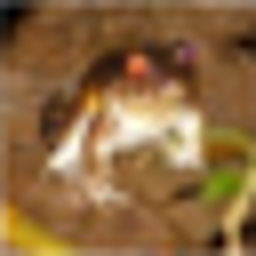

物体クラス: truck


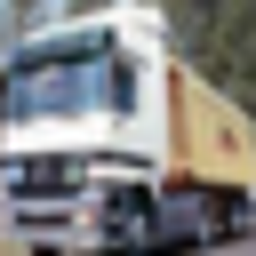

物体クラス: deer


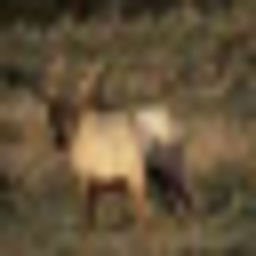

物体クラス: automobile


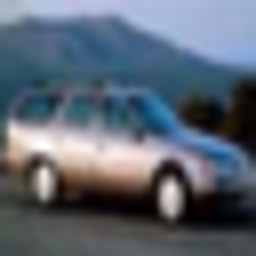

物体クラス: bird


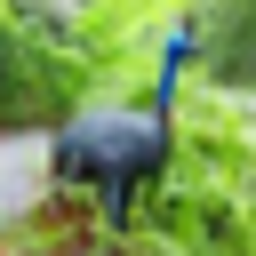

物体クラス: horse


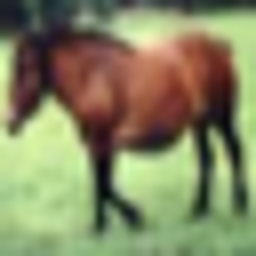

物体クラス: ship


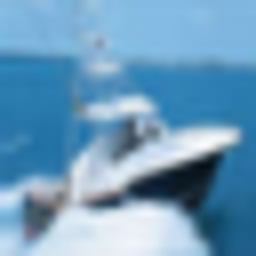

物体クラス: cat


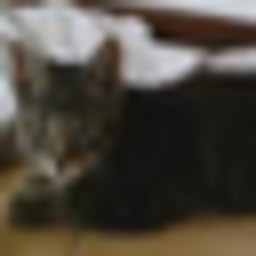

物体クラス: dog


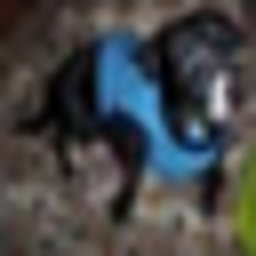

物体クラス: airplane


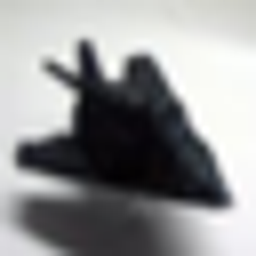

In [ ]:
# 表示済みの画像のラベルを保存する変数
displayed_classes = set()
i = 0
# 全てのラベルの画像を1枚ずつ表示するまでループ
while i < len(dataset) and \
      len(displayed_classes) < len(dataset.classes):
    # インデックスを使って1サンプルを取得
    img, label = dataset[i]
    if label not in displayed_classes:
        print(f'物体クラス: {dataset.classes[label]}')

        # 元画像が小さいので、リサイズして表示
        img = img.resize((256, 256))
        display(img)

        # 表示済みラベルの追加
        displayed_classes.add(label)

    i += 1

###データ分布の可視化

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


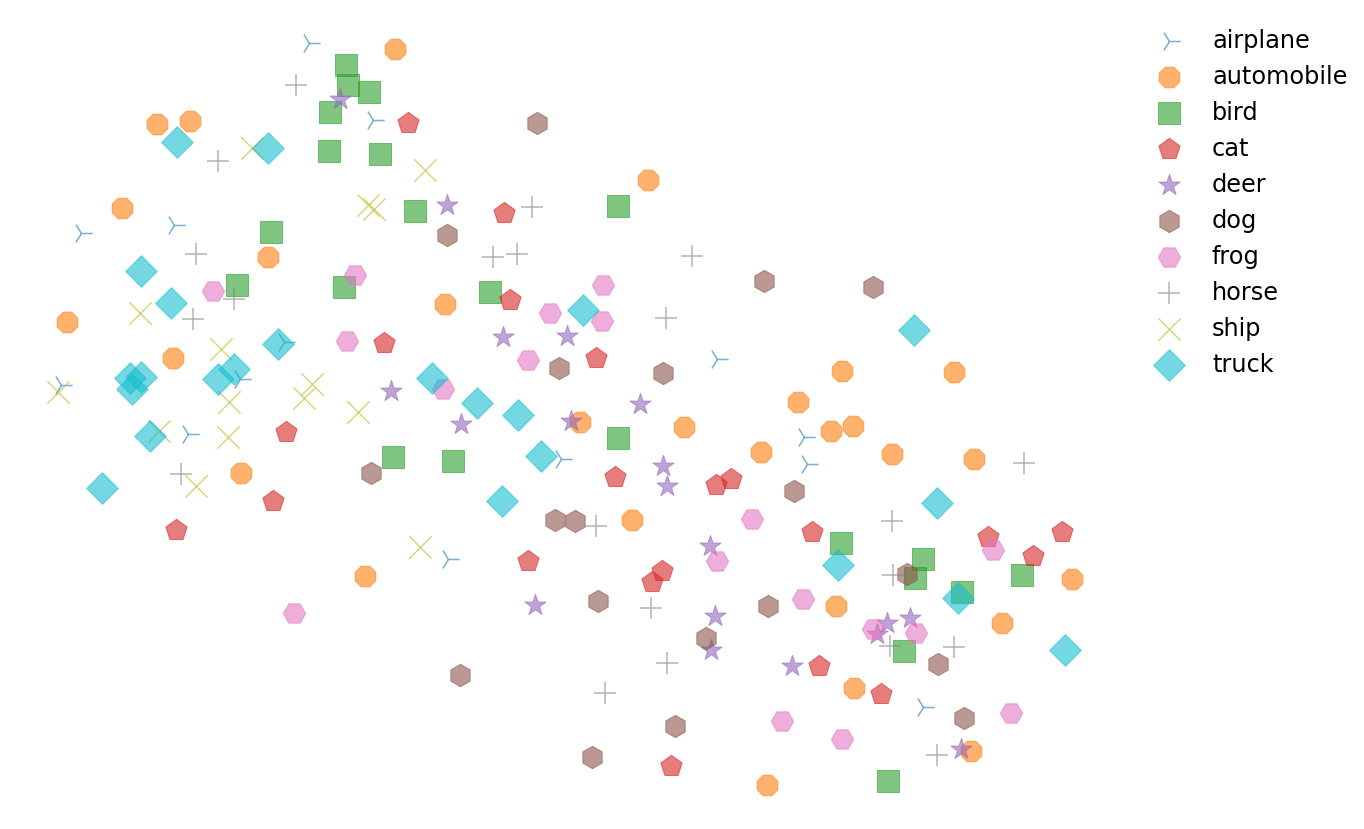

In [ ]:
# t-SNEのためにデータを整形
x = []
y = []
num_samples = 200
for i in range(num_samples):
    img, label = dataset[i]

    # 画像を平坦化 ([32, 32, 3] -> [3027]に変換)
    img_flatten = np.asarray(img).flatten()
    x.append(img_flatten)
    y.append(label)

# 全データをNumPy配列に統合
x = np.stack(x)
y = np.array(y)

# t-SNEを適用
t_sne = TSNE(n_components=2, random_state=0)
x_reduced = t_sne.fit_transform(x)

# 各ラベルの色とマーカーを設定
cmap = plt.get_cmap("tab10")
markers = ['4', '8', 's', 'p', '*', 'h', 'H', '+', 'x', 'D']

# データをプロット
plt.figure(figsize=(20, 15))
for i, cls in enumerate(dataset.classes):
    plt.scatter(x_reduced[y == i, 0], x_reduced[y == i, 1],
                c=[cmap(i / len(dataset.classes))],
                marker=markers[i], s=500, alpha=0.6, label=cls)
plt.axis('off')
plt.legend(bbox_to_anchor=(1, 1), fontsize=24, framealpha=0)
plt.show()

###データセットを分割するための2つの排反なインデックス集合を生成する関数

In [ ]:
'''
dataset    : 分割対象のデータセット
ratio      : 1つ目のセットに含めるデータ量の割合
random_seed: 分割結果を不変にするためのシード
'''
def generate_subset(dataset: Dataset, ratio: float,
                    random_seed: int=0):
    # サブセットの大きさを計算
    size = int(len(dataset) * ratio)

    indices = list(range(len(dataset)))

    # 二つのセットに分ける前にシャッフル
    random.seed(random_seed)
    random.shuffle(indices)

    # セット1とセット2のサンプルのインデックスに分割
    indices1, indices2 = indices[:size], indices[size:]

    return indices1, indices2

###学習、検証およびテストセットの生成と各セットの大きさの確認

In [ ]:
# 学習、テストセットの用意
train_dataset = torchvision.datasets.CIFAR10(
    root='data', train=True, download=True)
test_dataset = torchvision.datasets.CIFAR10(
    root='data', train=False, download=True)

# 学習セットのうち、検証セットに使う割合
val_ratio = 0.2

# Subsetの生成
val_set, train_set = generate_subset(train_dataset, val_ratio)

print(f'学習セットのサンプル数　: {len(train_set)}')
print(f'検証セットのサンプル数　: {len(val_set)}')
print(f'テストセットのサンプル数: {len(test_dataset)}')

Files already downloaded and verified
Files already downloaded and verified
学習セットのサンプル数　: 40000
検証セットのサンプル数　: 10000
テストセットのサンプル数: 10000


###画像整形関数

In [ ]:
'''
img         : 整形対象の画像
channel_mean: 各次元のデータセット全体の平均, [入力次元]
channel_std : 各次元のデータセット全体の標準偏差, [入力次元]
'''
def transform(img: Image.Image, channel_mean: np.ndarray=None,
              channel_std: np.ndarray=None):
    # PILからNumPy配列に変換
    img = np.asarray(img, dtype='float32')

    # [32, 32, 3]の画像を3072次元のベクトルに平坦化
    x = img.flatten()

    # 各次元をデータセット全体の平均と標準偏差で正規化
    if channel_mean is not None and channel_std is not None:
        x = (x - channel_mean) / channel_std

    return x

###各次元のデータセット全体の平均と標準偏差を計算する関数

In [ ]:
'''
dataset: 平均と標準偏差を計算する対象のPyTorchのデータセット
'''
def get_dataset_statistics(dataset: Dataset):
    data = []
    for i in range(len(dataset)):
        # 3072次元のベクトルを取得
        img_flat = dataset[i][0]
        data.append(img_flat)
    # 第0軸を追加して第0軸でデータを連結
    data = np.stack(data)

    # データ全体の平均と標準偏差を計算
    channel_mean = np.mean(data, axis=0)
    channel_std = np.std(data, axis=0)

    return channel_mean, channel_std

###ラベル整形関数

In [ ]:
'''
label      : 物体クラスラベル
num_classes: データセットの物体クラス数
'''
def target_transform(label: int, num_classes: int=10):
    # 数字 -> One-hotに変換
    y = np.identity(num_classes)[label]

    return y

###データ整形処理の確認

In [ ]:
# 各次元のデータセット全体の平均と標準偏差を計算
dataset = torchvision.datasets.CIFAR10(
    root='data', train=True, download=True, transform=transform)
channel_mean, channel_std = get_dataset_statistics(dataset)

# 正規化を含めた画像整形関数の用意
img_transform = lambda x: transform(x, channel_mean, channel_std)

# 整形関数を渡してデータセットクラスインスタンスを生成
dataset = torchvision.datasets.CIFAR10(
    root='data', train=True, download=True,
    transform=img_transform, target_transform=target_transform)

# データのサンプルと表示
img, label = dataset[0]
print(f'画像　: {img}')
print(f'ラベル: {label}')

Files already downloaded and verified
Files already downloaded and verified
画像　: [-0.97683984 -1.015768   -0.8645673  ... -0.05604946 -0.54032654
 -0.64139867]
ラベル: [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]


###多クラスロジスティック回帰

In [ ]:
class MultiClassLogisticRegression:
    '''
    多クラスロジスティック回帰
    dim_input  : 入力次元
    num_classes: 分類対象の物体クラス数
    '''
    def __init__(self, dim_input: int, num_classes: int):
        # パラメータの初期化
        self.weight = np.random.normal(scale=0.01,
                                       size=(dim_input, num_classes))
        self.bias = np.zeros(num_classes)
    
    '''
    内部用ソフトマックス関数
    x: ロジット, [バッチサイズ, 物体クラス数]
    '''
    def _softmax(self, x: np.ndarray):
        return np.exp(x) / np.sum(np.exp(x), axis=1, keepdims=True)

    '''
    物体クラスの確率を予測する関数
    x: 入力データ, [バッチサイズ, 入力次元]
    '''
    def predict(self, x: np.ndarray):
        # 入力に線形識別関数を適用
        y = np.matmul(x, self.weight) + self.bias
        y = self._softmax(y)

        return y

    '''
    パラメータを更新する関数
    x     : 入力データ,              [バッチサイズ, 入力次元]
    y     : One-hot表現されたラベル, [バッチサイズ, 物体クラス数]
    y_pred: 予測確率,                [バッチサイズ, 物体クラス数]
    lr    : 学習率
    '''
    def update_parameters(self, x: np.ndarray, y: np.ndarray,
                          y_pred: np.ndarray, lr: float=0.001):
        # 出力と正解の誤差を計算
        diffs = y_pred - y

        # 勾配を使ってパラメータを更新
        self.weight -= lr * np.mean(
            x[:, :, np.newaxis] * diffs[:, np.newaxis], axis=0)
        self.bias -= lr * np.mean(diffs, axis=0)

    '''
    モデルを複製して返す関数
    '''
    def copy(self):
        model_copy = self.__class__(*self.weight.shape)
        model_copy.weight = self.weight.copy()
        model_copy.bias = self.bias.copy()

        return model_copy

###モデル出力の確認

In [ ]:
# モデルの生成、初期化
model = MultiClassLogisticRegression(32 * 32 * 3, 10)

# バッチサイズ1でランダムな入力を生成
x = np.random.normal(size=(1, 32 * 32 * 3))

# 予測
y = model.predict(x)

print(f'予測確率: {y[0]}')

予測確率: [0.11227839 0.10732677 0.05854553 0.11813351 0.14348287 0.07281357
 0.08777638 0.08197543 0.1124672  0.10520035]


###学習・評価におけるハイパーパラメータやオプションの設定

In [ ]:
class Config:
    '''
    ハイパーパラメータとオプションの設定
    '''
    def __init__(self):
        # 検証に使う学習セット内のデータの割合
        self.val_ratio = 0.2
        # 学習エポック数
        self.num_epochs = 30
        # 検証する学習率
        self.lrs = [1e-2, 1e-3, 1e-4]
        # 移動平均で計算する損失と正確度の値の数
        self.moving_avg = 20
        # バッチサイズ
        self.batch_size = 32
        # データローダーに使うCPUプロセスの数
        self.num_workers = 2

###学習・評価を行う関数

In [ ]:
def train_eval():
    config = Config()

    # 入力データ正規化のために学習セットのデータを使って
    # 各次元の平均と標準偏差を計算
    dataset = torchvision.datasets.CIFAR10(
        root='data', train=True, download=True, transform=transform)
    channel_mean, channel_std = get_dataset_statistics(dataset)

    # 正規化を含めた画像整形関数の用意
    img_transform = lambda x: transform(x, channel_mean, channel_std)

    # 学習、評価セットの用意
    train_dataset = torchvision.datasets.CIFAR10(
        root='data', train=True, download=True,
        transform=img_transform, target_transform=target_transform)
    test_dataset = torchvision.datasets.CIFAR10(
        root='data', train=False, download=True,
        transform=img_transform, target_transform=target_transform)

    # 学習・検証セットへ分割するためのインデックス集合の生成
    val_set, train_set = generate_subset(
        train_dataset, config.val_ratio)

    print(f'学習セットのサンプル数　: {len(train_set)}')
    print(f'検証セットのサンプル数　: {len(val_set)}')
    print(f'テストセットのサンプル数: {len(test_dataset)}')

    # インデックス集合から無作為にインデックスをサンプルするサンプラー
    train_sampler = SubsetRandomSampler(train_set)

    # DataLoaderを生成
    train_loader = DataLoader(
        train_dataset, batch_size=config.batch_size,
        num_workers=config.num_workers, sampler=train_sampler)
    val_loader = DataLoader(
        train_dataset, batch_size=config.batch_size,
        num_workers=config.num_workers, sampler=val_set)
    test_loader = DataLoader(
        test_dataset, batch_size=config.batch_size,
        num_workers=config.num_workers)

    # 検証セットの結果による最良モデルの保存用変数
    val_loss_best = float('inf')
    model_best = None
    for lr in config.lrs:
        print(f'学習率: {lr}')

        # 多クラスロジスティック回帰モデルの生成
        model = MultiClassLogisticRegression(
            32 * 32 * 3, len(train_dataset.classes))

        for epoch in range(config.num_epochs):
            with tqdm(train_loader) as pbar:
                pbar.set_description(f'[エポック {epoch + 1}]')

                # 移動平均計算用
                losses = deque()
                accs = deque()
                for x, y in pbar:
                    # サンプルしたデータはPyTorchのTensorに
                    # 変換されているのためNumPyデータに戻す
                    x = x.numpy()
                    y = y.numpy()

                    y_pred = model.predict(x)

                    # 学習データに対する目的関数と正確度を計算
                    loss = np.mean(
                        np.sum(-y * np.log(y_pred), axis=1))
                    # Maxのインデックスは数字表現のクラスラベル
                    accuracy = np.mean(np.argmax(y_pred, axis=1) == \
                                       np.argmax(y, axis=1))

                    # 移動平均を計算して表示
                    losses.append(loss)
                    accs.append(accuracy)
                    if len(losses) > config.moving_avg:
                        losses.popleft()
                        accs.popleft()
                    pbar.set_postfix({'loss': np.mean(losses),
                                      'accuracy': np.mean(accs)})

                    # パラメータを更新
                    model.update_parameters(x, y, y_pred, lr=lr)

            # 検証セットを使って精度評価
            val_loss, val_accuracy = evaluate(val_loader, model)
            print(f'検証　: loss = {val_loss:.3f}, '
                  f'accuracy = {val_accuracy:.3f}')

            # より良い検証結果が得られた場合、モデルを記録
            if val_loss < val_loss_best:
                val_loss_best = val_loss
                model_best = model.copy()

    # テスト
    test_loss, test_accuracy = evaluate(test_loader, model_best)
    print(f'テスト: loss = {test_loss:.3f}, '
          f'accuracy = {test_accuracy:.3f}')


###評価関数

In [ ]:
'''
data_loader: 評価に使うデータを読み込むデータローダ
model      : 評価対象のモデル
'''
def evaluate(data_loader: DataLoader,
             model: MultiClassLogisticRegression):
    losses = []
    preds = []
    for x, y in data_loader:
        x = x.numpy()
        y = y.numpy()

        y_pred = model.predict(x)

        losses.append(np.sum(-y * np.log(y_pred), axis=1))

        preds.append(np.argmax(y_pred, axis=1) == \
                     np.argmax(y, axis=1))

    loss = np.mean(np.concatenate(losses))
    accuracy = np.mean(np.concatenate(preds))

    return loss, accuracy

###学習・評価の実行

In [ ]:
train_eval()

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
学習セットのサンプル数　: 40000
検証セットのサンプル数　: 10000
テストセットのサンプル数: 10000
学習率: 0.01


[エポック 1]: 100%|██████████| 1250/1250 [00:20<00:00, 61.40it/s, loss=1.87, accuracy=0.35]


検証　: loss = 1.856, accuracy = 0.376


[エポック 2]: 100%|██████████| 1250/1250 [00:21<00:00, 57.44it/s, loss=1.95, accuracy=0.333]


検証　: loss = 1.905, accuracy = 0.363


[エポック 3]: 100%|██████████| 1250/1250 [00:24<00:00, 50.11it/s, loss=1.87, accuracy=0.375]


検証　: loss = 1.905, accuracy = 0.357


[エポック 4]: 100%|██████████| 1250/1250 [00:23<00:00, 53.30it/s, loss=1.9, accuracy=0.35]


検証　: loss = 1.891, accuracy = 0.364


[エポック 5]: 100%|██████████| 1250/1250 [00:22<00:00, 54.98it/s, loss=1.89, accuracy=0.389]


検証　: loss = 1.917, accuracy = 0.349


[エポック 6]: 100%|██████████| 1250/1250 [00:22<00:00, 56.33it/s, loss=1.87, accuracy=0.38]


検証　: loss = 1.964, accuracy = 0.356


[エポック 7]: 100%|██████████| 1250/1250 [00:21<00:00, 57.76it/s, loss=1.88, accuracy=0.367]


検証　: loss = 1.958, accuracy = 0.360


[エポック 8]: 100%|██████████| 1250/1250 [00:22<00:00, 54.98it/s, loss=1.88, accuracy=0.383]


検証　: loss = 1.910, accuracy = 0.362


[エポック 9]: 100%|██████████| 1250/1250 [00:22<00:00, 55.40it/s, loss=1.84, accuracy=0.395]


検証　: loss = 1.963, accuracy = 0.350


[エポック 10]: 100%|██████████| 1250/1250 [00:22<00:00, 54.47it/s, loss=1.96, accuracy=0.334]


検証　: loss = 1.961, accuracy = 0.357


[エポック 11]: 100%|██████████| 1250/1250 [00:22<00:00, 56.61it/s, loss=1.8, accuracy=0.388]


検証　: loss = 1.939, accuracy = 0.360


[エポック 12]: 100%|██████████| 1250/1250 [00:23<00:00, 52.43it/s, loss=1.79, accuracy=0.423]


検証　: loss = 1.938, accuracy = 0.362


[エポック 13]: 100%|██████████| 1250/1250 [00:22<00:00, 55.04it/s, loss=1.84, accuracy=0.402]


検証　: loss = 1.984, accuracy = 0.343


[エポック 14]: 100%|██████████| 1250/1250 [00:23<00:00, 53.83it/s, loss=1.79, accuracy=0.405]


検証　: loss = 1.996, accuracy = 0.356


[エポック 15]: 100%|██████████| 1250/1250 [00:22<00:00, 55.63it/s, loss=1.8, accuracy=0.378]


検証　: loss = 1.985, accuracy = 0.344


[エポック 16]: 100%|██████████| 1250/1250 [00:23<00:00, 52.93it/s, loss=1.74, accuracy=0.42]


検証　: loss = 1.952, accuracy = 0.353


[エポック 17]: 100%|██████████| 1250/1250 [00:23<00:00, 53.89it/s, loss=1.8, accuracy=0.384]


検証　: loss = 1.956, accuracy = 0.350


[エポック 18]: 100%|██████████| 1250/1250 [00:22<00:00, 56.26it/s, loss=1.78, accuracy=0.4]


検証　: loss = 1.936, accuracy = 0.369


[エポック 19]: 100%|██████████| 1250/1250 [00:23<00:00, 53.01it/s, loss=1.83, accuracy=0.391]


検証　: loss = 1.960, accuracy = 0.364


[エポック 20]: 100%|██████████| 1250/1250 [00:22<00:00, 54.51it/s, loss=1.82, accuracy=0.377]


検証　: loss = 1.954, accuracy = 0.366


[エポック 21]: 100%|██████████| 1250/1250 [00:22<00:00, 55.41it/s, loss=1.84, accuracy=0.372]


検証　: loss = 2.008, accuracy = 0.355


[エポック 22]: 100%|██████████| 1250/1250 [00:22<00:00, 56.53it/s, loss=1.8, accuracy=0.411]


検証　: loss = 2.050, accuracy = 0.332


[エポック 23]: 100%|██████████| 1250/1250 [00:23<00:00, 53.54it/s, loss=1.72, accuracy=0.423]


検証　: loss = 1.977, accuracy = 0.365


[エポック 24]: 100%|██████████| 1250/1250 [00:22<00:00, 55.00it/s, loss=1.87, accuracy=0.358]


検証　: loss = 1.950, accuracy = 0.361


[エポック 25]: 100%|██████████| 1250/1250 [00:22<00:00, 54.58it/s, loss=1.71, accuracy=0.433]


検証　: loss = 1.970, accuracy = 0.356


[エポック 26]: 100%|██████████| 1250/1250 [00:24<00:00, 51.89it/s, loss=1.85, accuracy=0.394]


検証　: loss = 1.953, accuracy = 0.357


[エポック 27]: 100%|██████████| 1250/1250 [00:22<00:00, 55.59it/s, loss=1.8, accuracy=0.427]


検証　: loss = 1.966, accuracy = 0.354


[エポック 28]: 100%|██████████| 1250/1250 [00:25<00:00, 49.22it/s, loss=1.85, accuracy=0.386]


検証　: loss = 2.048, accuracy = 0.335


[エポック 29]: 100%|██████████| 1250/1250 [00:23<00:00, 52.75it/s, loss=1.77, accuracy=0.409]


検証　: loss = 1.986, accuracy = 0.360


[エポック 30]: 100%|██████████| 1250/1250 [00:23<00:00, 53.75it/s, loss=1.77, accuracy=0.4]


検証　: loss = 1.998, accuracy = 0.351
学習率: 0.001


[エポック 1]: 100%|██████████| 1250/1250 [00:23<00:00, 54.20it/s, loss=1.79, accuracy=0.378]


検証　: loss = 1.801, accuracy = 0.383


[エポック 2]: 100%|██████████| 1250/1250 [00:24<00:00, 51.82it/s, loss=1.72, accuracy=0.428]


検証　: loss = 1.770, accuracy = 0.392


[エポック 3]: 100%|██████████| 1250/1250 [00:22<00:00, 55.00it/s, loss=1.77, accuracy=0.369]


検証　: loss = 1.757, accuracy = 0.402


[エポック 4]: 100%|██████████| 1250/1250 [00:22<00:00, 54.57it/s, loss=1.68, accuracy=0.45]


検証　: loss = 1.744, accuracy = 0.406


[エポック 5]: 100%|██████████| 1250/1250 [00:23<00:00, 53.89it/s, loss=1.74, accuracy=0.425]


検証　: loss = 1.738, accuracy = 0.408


[エポック 6]: 100%|██████████| 1250/1250 [00:22<00:00, 54.64it/s, loss=1.68, accuracy=0.416]


検証　: loss = 1.736, accuracy = 0.406


[エポック 7]: 100%|██████████| 1250/1250 [00:23<00:00, 53.80it/s, loss=1.73, accuracy=0.423]


検証　: loss = 1.735, accuracy = 0.408


[エポック 8]: 100%|██████████| 1250/1250 [00:21<00:00, 58.40it/s, loss=1.62, accuracy=0.444]


検証　: loss = 1.734, accuracy = 0.409


[エポック 9]: 100%|██████████| 1250/1250 [00:24<00:00, 51.70it/s, loss=1.68, accuracy=0.438]


検証　: loss = 1.737, accuracy = 0.407


[エポック 10]: 100%|██████████| 1250/1250 [00:23<00:00, 53.99it/s, loss=1.72, accuracy=0.394]


検証　: loss = 1.732, accuracy = 0.406


[エポック 11]: 100%|██████████| 1250/1250 [00:22<00:00, 54.70it/s, loss=1.65, accuracy=0.452]


検証　: loss = 1.734, accuracy = 0.405


[エポック 12]: 100%|██████████| 1250/1250 [00:22<00:00, 55.29it/s, loss=1.71, accuracy=0.408]


検証　: loss = 1.729, accuracy = 0.407


[エポック 13]: 100%|██████████| 1250/1250 [00:23<00:00, 53.56it/s, loss=1.71, accuracy=0.397]


検証　: loss = 1.733, accuracy = 0.406


[エポック 14]: 100%|██████████| 1250/1250 [00:22<00:00, 55.02it/s, loss=1.59, accuracy=0.461]


検証　: loss = 1.732, accuracy = 0.407


[エポック 15]: 100%|██████████| 1250/1250 [00:22<00:00, 55.63it/s, loss=1.68, accuracy=0.423]


検証　: loss = 1.729, accuracy = 0.409


[エポック 16]: 100%|██████████| 1250/1250 [00:23<00:00, 53.68it/s, loss=1.62, accuracy=0.439]


検証　: loss = 1.733, accuracy = 0.408


[エポック 17]: 100%|██████████| 1250/1250 [00:22<00:00, 56.08it/s, loss=1.7, accuracy=0.439]


検証　: loss = 1.730, accuracy = 0.409


[エポック 18]: 100%|██████████| 1250/1250 [00:21<00:00, 58.16it/s, loss=1.69, accuracy=0.438]


検証　: loss = 1.729, accuracy = 0.408


[エポック 19]: 100%|██████████| 1250/1250 [00:22<00:00, 55.51it/s, loss=1.72, accuracy=0.4]


検証　: loss = 1.730, accuracy = 0.407


[エポック 20]: 100%|██████████| 1250/1250 [00:22<00:00, 55.59it/s, loss=1.66, accuracy=0.405]


検証　: loss = 1.729, accuracy = 0.409


[エポック 21]: 100%|██████████| 1250/1250 [00:22<00:00, 55.76it/s, loss=1.66, accuracy=0.434]


検証　: loss = 1.737, accuracy = 0.405


[エポック 22]: 100%|██████████| 1250/1250 [00:22<00:00, 56.68it/s, loss=1.64, accuracy=0.434]


検証　: loss = 1.733, accuracy = 0.407


[エポック 23]: 100%|██████████| 1250/1250 [00:23<00:00, 53.97it/s, loss=1.59, accuracy=0.461]


検証　: loss = 1.728, accuracy = 0.410


[エポック 24]: 100%|██████████| 1250/1250 [00:22<00:00, 56.23it/s, loss=1.61, accuracy=0.484]


検証　: loss = 1.729, accuracy = 0.408


[エポック 25]: 100%|██████████| 1250/1250 [00:22<00:00, 56.66it/s, loss=1.69, accuracy=0.42]


検証　: loss = 1.730, accuracy = 0.407


[エポック 26]: 100%|██████████| 1250/1250 [00:23<00:00, 53.68it/s, loss=1.72, accuracy=0.405]


検証　: loss = 1.729, accuracy = 0.409


[エポック 27]: 100%|██████████| 1250/1250 [00:22<00:00, 55.21it/s, loss=1.6, accuracy=0.45]


検証　: loss = 1.733, accuracy = 0.409


[エポック 28]: 100%|██████████| 1250/1250 [00:22<00:00, 56.08it/s, loss=1.62, accuracy=0.456]


検証　: loss = 1.733, accuracy = 0.408


[エポック 29]: 100%|██████████| 1250/1250 [00:21<00:00, 57.15it/s, loss=1.52, accuracy=0.498]


検証　: loss = 1.736, accuracy = 0.401


[エポック 30]: 100%|██████████| 1250/1250 [00:23<00:00, 54.07it/s, loss=1.64, accuracy=0.453]


検証　: loss = 1.739, accuracy = 0.404
学習率: 0.0001


[エポック 1]: 100%|██████████| 1250/1250 [00:21<00:00, 56.91it/s, loss=1.99, accuracy=0.314]


検証　: loss = 1.968, accuracy = 0.308


[エポック 2]: 100%|██████████| 1250/1250 [00:22<00:00, 56.66it/s, loss=1.93, accuracy=0.328]


検証　: loss = 1.899, accuracy = 0.339


[エポック 3]: 100%|██████████| 1250/1250 [00:22<00:00, 54.94it/s, loss=1.83, accuracy=0.366]


検証　: loss = 1.865, accuracy = 0.356


[エポック 4]: 100%|██████████| 1250/1250 [00:22<00:00, 56.26it/s, loss=1.81, accuracy=0.37]


検証　: loss = 1.844, accuracy = 0.366


[エポック 5]: 100%|██████████| 1250/1250 [00:22<00:00, 55.33it/s, loss=1.82, accuracy=0.358]


検証　: loss = 1.828, accuracy = 0.374


[エポック 6]: 100%|██████████| 1250/1250 [00:22<00:00, 55.21it/s, loss=1.86, accuracy=0.352]


検証　: loss = 1.817, accuracy = 0.378


[エポック 7]: 100%|██████████| 1250/1250 [00:23<00:00, 53.03it/s, loss=1.78, accuracy=0.391]


検証　: loss = 1.807, accuracy = 0.385


[エポック 8]: 100%|██████████| 1250/1250 [00:22<00:00, 56.01it/s, loss=1.87, accuracy=0.356]


検証　: loss = 1.799, accuracy = 0.389


[エポック 9]: 100%|██████████| 1250/1250 [00:22<00:00, 56.21it/s, loss=1.83, accuracy=0.392]


検証　: loss = 1.793, accuracy = 0.393


[エポック 10]: 100%|██████████| 1250/1250 [00:22<00:00, 55.06it/s, loss=1.79, accuracy=0.381]


検証　: loss = 1.787, accuracy = 0.393


[エポック 11]: 100%|██████████| 1250/1250 [00:21<00:00, 57.66it/s, loss=1.74, accuracy=0.419]


検証　: loss = 1.782, accuracy = 0.396


[エポック 12]: 100%|██████████| 1250/1250 [00:23<00:00, 53.98it/s, loss=1.77, accuracy=0.397]


検証　: loss = 1.778, accuracy = 0.398


[エポック 13]: 100%|██████████| 1250/1250 [00:22<00:00, 55.82it/s, loss=1.74, accuracy=0.417]


検証　: loss = 1.776, accuracy = 0.397


[エポック 14]: 100%|██████████| 1250/1250 [00:22<00:00, 54.52it/s, loss=1.77, accuracy=0.397]


検証　: loss = 1.771, accuracy = 0.402


[エポック 15]: 100%|██████████| 1250/1250 [00:22<00:00, 56.02it/s, loss=1.72, accuracy=0.423]


検証　: loss = 1.768, accuracy = 0.400


[エポック 16]: 100%|██████████| 1250/1250 [00:22<00:00, 55.31it/s, loss=1.72, accuracy=0.419]


検証　: loss = 1.767, accuracy = 0.400


[エポック 17]: 100%|██████████| 1250/1250 [00:22<00:00, 55.07it/s, loss=1.75, accuracy=0.416]


検証　: loss = 1.763, accuracy = 0.404


[エポック 18]: 100%|██████████| 1250/1250 [00:22<00:00, 55.71it/s, loss=1.7, accuracy=0.412]


検証　: loss = 1.761, accuracy = 0.403


[エポック 19]: 100%|██████████| 1250/1250 [00:22<00:00, 55.76it/s, loss=1.77, accuracy=0.423]


検証　: loss = 1.759, accuracy = 0.403


[エポック 20]: 100%|██████████| 1250/1250 [00:21<00:00, 56.89it/s, loss=1.75, accuracy=0.383]


検証　: loss = 1.757, accuracy = 0.405


[エポック 21]: 100%|██████████| 1250/1250 [00:23<00:00, 53.12it/s, loss=1.68, accuracy=0.436]


検証　: loss = 1.755, accuracy = 0.404


[エポック 22]: 100%|██████████| 1250/1250 [00:22<00:00, 54.63it/s, loss=1.73, accuracy=0.386]


検証　: loss = 1.754, accuracy = 0.406


[エポック 23]: 100%|██████████| 1250/1250 [00:23<00:00, 54.24it/s, loss=1.71, accuracy=0.408]


検証　: loss = 1.752, accuracy = 0.405


[エポック 24]: 100%|██████████| 1250/1250 [00:22<00:00, 55.00it/s, loss=1.71, accuracy=0.43]


検証　: loss = 1.750, accuracy = 0.406


[エポック 25]: 100%|██████████| 1250/1250 [00:23<00:00, 54.20it/s, loss=1.71, accuracy=0.414]


検証　: loss = 1.748, accuracy = 0.407


[エポック 26]: 100%|██████████| 1250/1250 [00:23<00:00, 53.52it/s, loss=1.75, accuracy=0.411]


検証　: loss = 1.748, accuracy = 0.405


[エポック 27]: 100%|██████████| 1250/1250 [00:22<00:00, 54.86it/s, loss=1.66, accuracy=0.444]


検証　: loss = 1.746, accuracy = 0.408


[エポック 28]: 100%|██████████| 1250/1250 [00:24<00:00, 52.01it/s, loss=1.68, accuracy=0.463]


検証　: loss = 1.745, accuracy = 0.409


[エポック 29]: 100%|██████████| 1250/1250 [00:22<00:00, 54.73it/s, loss=1.75, accuracy=0.389]


検証　: loss = 1.743, accuracy = 0.409


[エポック 30]: 100%|██████████| 1250/1250 [00:23<00:00, 53.98it/s, loss=1.73, accuracy=0.438]


検証　: loss = 1.743, accuracy = 0.411
テスト: loss = 1.726, accuracy = 0.405
